Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
%matplotlib inline
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import nltk

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [5]:
print(data[0:3])
print(reverse_dictionary[list(reverse_dictionary.keys())[237]])

[5234, 3081, 12]
west


Function to generate a training batch for the skip-gram model.

In [6]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['originated', 'anarchism', 'term', 'a', 'originated', 'as', 'term', 'of']


Train a skip-gram model.

In [7]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [8]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.883247
Nearest to people: mishnayot, riches, deadheads, graphite, hepatitis, boosting, sns, craftsman,
Nearest to often: waning, exhausting, spencer, digestion, reductionism, gout, regularly, mirza,
Nearest to during: maior, oneworld, servers, somehow, aspartame, halifax, debtors, fundraising,
Nearest to were: frieze, boron, pequod, arcs, tocantins, smooth, equally, genders,
Nearest to state: eikon, sondheim, tdma, effluents, premises, saville, reducible, prefrontal,
Nearest to been: newbies, inorganic, carrier, rhythmic, fairies, zombie, relocated, globes,
Nearest to they: liters, adjutant, freeway, edt, kirk, sinti, infusions, glasgow,
Nearest to for: diarrhea, jd, informational, overridden, nasty, rockingham, homeomorphisms, hostile,
Nearest to be: cadiz, sourcewatch, sharp, iu, crosses, akrotiri, lambasted, conception,
Nearest to that: behaves, iberian, baserunners, restart, territory, boulders, fgm, mumia,
Nearest to when: compagnie, licensing

Average loss at step 52000: 3.436969
Average loss at step 54000: 3.423066
Average loss at step 56000: 3.439931
Average loss at step 58000: 3.395166
Average loss at step 60000: 3.395513
Nearest to people: ethiopians, writers, scientists, women, members, children, shanghainese, players,
Nearest to often: usually, sometimes, generally, now, commonly, typically, frequently, also,
Nearest to during: after, at, since, in, when, following, before, although,
Nearest to were: are, was, have, had, those, been, be, although,
Nearest to state: government, states, nature, effluents, dum, amusement, ket, sic,
Nearest to been: become, be, was, already, were, mulatto, shifted, latterly,
Nearest to they: we, there, he, you, she, not, it, who,
Nearest to for: including, of, after, enciclopedia, transliterations, if, spire, or,
Nearest to be: been, produce, char, have, was, become, is, arrange,
Nearest to that: which, what, this, however, escalator, citation, there, who,
Nearest to when: if, although, wh

In [9]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

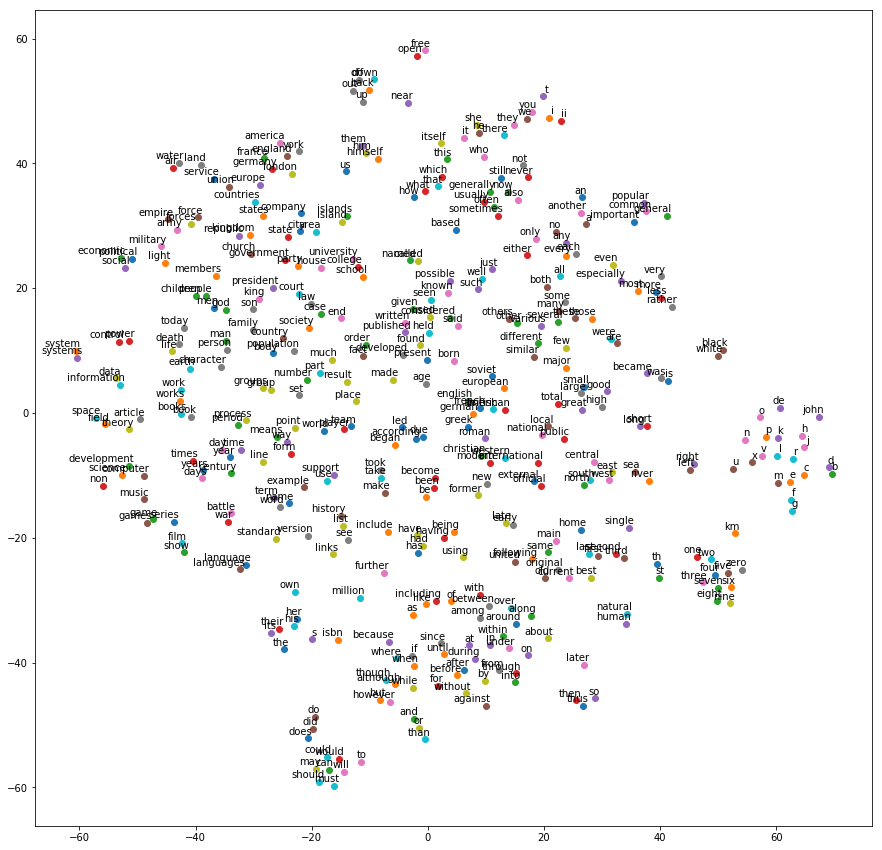

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [18]:
def rem_stopwords(data, stopwords):
    buffer = []
    for word in data:
        if(word not in stopwords):
            buffer.append(word)
    return buffer

In [19]:
def read_and_filter_data():
    words = read_data(filename)
    print('word sample', words[:10])
    stopwords = nltk.corpus.stopwords.words('english')
    print('num of words before extracting stopwords', len(words))
    print('stopwords sample', stopwords[:10])
    print('num of stopwords', len(stopwords))    
    
    filt_w = rem_stopwords(words, stopwords)
    print('word sample (after extraction)', filt_w[:10])
    print('num of words after extracting stopwords', len(filt_w))
    return filt_w

words = read_and_filter_data()

word sample ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
num of words before extracting stopwords 17005207
stopwords sample ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
num of stopwords 179
word sample (after extraction) ['anarchism', 'originated', 'term', 'abuse', 'first', 'used', 'early', 'working', 'class', 'radicals']
num of words after extracting stopwords 10890638


In [38]:
vocabulary_size = 10000

def most_frequent_words(words):
    count = collections.Counter(words).most_common(vocabulary_size-1)
    dictionary = dict()
    for i, (word, c) in enumerate(count):
        dictionary[word] = len(dictionary)
    return dictionary
    
def create_dataset(words):
    dictionary = most_frequent_words(words)
    encoded_data = []
    code = 0
    for word in words:
        if(word in dictionary):
            encoded_data.append(dictionary[word])
        else:
            encoded_data.append(0)
    print('encoded data', encoded_data[:10])
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary, encoded_data

dictionary, rev_dictionary, encoded_data = create_dataset(words)

encoded data [5103, 2955, 106, 3007, 11, 14, 51, 625, 369, 0]


In [21]:
i = 0
print(words[:10])
print('encoded data size',len(encoded_data),'max value', max(encoded_data))
for data in zip(dictionary.keys(), rev_dictionary.keys(), encoded_data):
    if(i >= 10):
        break
    dict_key = data[0]
    print('encoded_data:', data[2])
    print('rev_dict[encoded_data]', rev_dictionary[data[2]])
    print('dict[rev_dict[encoded_data]]:', dictionary[rev_dictionary[data[2]]])
    print('')
    i += 1

['anarchism', 'originated', 'term', 'abuse', 'first', 'used', 'early', 'working', 'class', 'radicals']
encoded data size 10890638 max value 9998
encoded_data: 5103
rev_dict[encoded_data] anarchism
dict[rev_dict[encoded_data]]: 5103

encoded_data: 2955
rev_dict[encoded_data] originated
dict[rev_dict[encoded_data]]: 2955

encoded_data: 106
rev_dict[encoded_data] term
dict[rev_dict[encoded_data]]: 106

encoded_data: 3007
rev_dict[encoded_data] abuse
dict[rev_dict[encoded_data]]: 3007

encoded_data: 11
rev_dict[encoded_data] first
dict[rev_dict[encoded_data]]: 11

encoded_data: 14
rev_dict[encoded_data] used
dict[rev_dict[encoded_data]]: 14

encoded_data: 51
rev_dict[encoded_data] early
dict[rev_dict[encoded_data]]: 51

encoded_data: 625
rev_dict[encoded_data] working
dict[rev_dict[encoded_data]]: 625

encoded_data: 369
rev_dict[encoded_data] class
dict[rev_dict[encoded_data]]: 369

encoded_data: 0
rev_dict[encoded_data] one
dict[rev_dict[encoded_data]]: 0



In [40]:
batch_window_pos = 0
def gen_batch(words, batch_size, skip_window, num_skips):
    global batch_window_pos
    input_words = np.ndarray(shape=(batch_size), dtype=np.int32)
    context = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    
    cur_batch = collections.deque(maxlen=span)
    #Moves the window, selecting the corresponding target word at each position
    for _ in range(span):
        cur_batch.append(words[batch_window_pos])
        cur_window_pos = (batch_window_pos + 1) % len(words)
    
    #Picks random context words around the target
    for i in range(batch_size // num_skips):
        chosen_word = skip_window
        #Structure to prevent picking repeated words
        invalid_words = [skip_window]
        for j in range(num_skips):
            while(chosen_word in invalid_words):
                chosen_word = random.randint(0, span-1)
                
            invalid_words.append(chosen_word)
            input_words[i*num_skips+j] = cur_batch[skip_window]
            context[i*num_skips+j, 0] = cur_batch[chosen_word]
        
    cur_batch.append(words[batch_window_pos])
    batch_window_pos = (batch_window_pos+1) % len(words)
    
    return input_words, context

In [34]:
#Picks a number of random integers between 0 and valid_window to serve as the validation set
valid_size = 16     # Number of integers to pick
valid_window = 100  # Range of each selected integer. In this case, 
valid_examples = np.random.choice(valid_window, valid_size, replace=False) 
#This line makes the selection. replace=False makes sure no number gets picked twice

In [45]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a context.

graph = tf.Graph()

with graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_context = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, tf.int32)
    
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    input_embeddings = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    weights = tf.Variable(tf.truncated_normal
                                  ([vocabulary_size, embedding_size], stddev=1.0/math.sqrt(embedding_size)))
    biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    logits = tf.matmul(input_embeddings, tf.transpose(weights))+biases
    
    onehot_context = tf.one_hot(train_context, vocabulary_size)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=onehot_context))
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [49]:
num_steps = 30000
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
        batch_inputs, batch_context = gen_batch(encoded_data, batch_size, skip_window, num_skips)
        feed_dict = { train_inputs: batch_inputs, train_context: batch_context }
        _, l = session.run([optimizer, loss], feed_dict = feed_dict)
        
        if(step % 500 == 0):
            print('step', step, 'loss', l)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

step 0 loss 8.336624
Nearest to world: deceased, christianity, powers, rouge, fa, miracle, encoded, rousseau,
Nearest to will: wrestler, which, max, hardware, publishers, ontario, vancouver, writings,
Nearest to has: procedures, thousand, evaluation, major, wake, monument, clement, proposition,
Nearest to called: var, hamlet, homo, sculptor, finds, privileges, consequence, lenin,
Nearest to some: accidentally, awareness, galaxy, malay, peter, sees, boost, compared,
Nearest to its: prelude, suspect, hunting, challenge, routledge, regime, prevailing, memorial,
Nearest to three: reserves, finnish, crust, prone, optimal, cultivation, kid, qu,
Nearest to was: absolutely, rendering, backs, object, masturbation, crushed, spectroscopy, stuck,
Nearest to not: mt, continuously, trotsky, staying, gandhi, innocent, karate, mandate,
Nearest to had: french, barcelona, dubbed, attended, reply, lowered, statue, achilles,
Nearest to th: tract, broad, albert, possessions, psychological, sexuality, impli